# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 3 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = \frac{1}{\pi}\cos(\pi x)
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(\frac{1}{\pi}\cos(\pi x)/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(\frac{1}{\pi}\cos(\pi x)/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
NAME = "1"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [25]:
xt = jnp.array([[-0.25, 0], [0.25, 0]])

def update_(xt):
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	return xt

update = jax.vmap(update_, in_axes = (0))
update(xt)

DeviceArray([[ 8.742278e-08, -1.000000e+00,  0.000000e+00],
             [-8.742278e-08, -1.000000e+00,  0.000000e+00]],            dtype=float32)

In [31]:
jnp.sin(2.*jnp.pi*1.0)

DeviceArray(1.7484555e-07, dtype=float32)

In [3]:
key = random.PRNGKey(1001)
key, subkey = random.split(key, 2)

layers = [3] + [32]*2 + [2] # (cos(2pi*x), sin(2pi*x), t) -> (u, v)
c0 = 6.0
# w0 = jnp.array([[1.0], [1.0]]) # (w_x, w_t)
w0 = 1.0
w1 = 1.0
lambda_0 = 1e-6
direct_params = init_siren_params(subkey, layers, c0, w0, w1)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]
epsilon = 1.0
V = 0.0

# @jax.jit
# def 

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1] <- enforce periodic bc
# 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
# 	xt = jnp.sin(2*jnp.pi*xt/(domain[1, :]-domain[0, :]))

	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	return loss_c, loss_d


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d, loss_c, loss_d

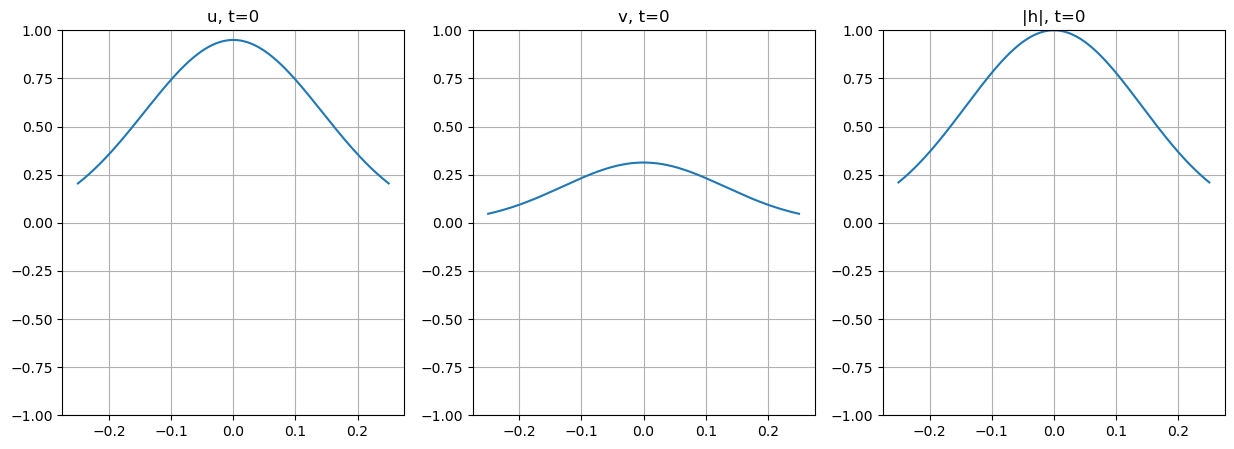

In [5]:
u0_fn = lambda x, t: np.exp(-25*x**2)*np.cos(1/(np.pi*epsilon)*np.cos(np.pi*x))
v0_fn = lambda x, t: np.exp(-25*x**2)*np.sin(1/(np.pi*epsilon)*np.cos(np.pi*x))
x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_cx = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = -1
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-2, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, [0, 0], n_cx, iterations, 1)

params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/11, 01:37:18, Iteration: 0, Train Loss: 3.0949e+00, c: 2.2689e+02, d: 8.2605e-01
2020/08/11, 01:37:24, Iteration: 1000, Train Loss: 2.5464e-01, c: 9.6516e-01, d: 2.4499e-01
2020/08/11, 01:37:30, Iteration: 2000, Train Loss: 1.5464e-01, c: 2.2702e+00, d: 1.3194e-01
2020/08/11, 01:37:36, Iteration: 3000, Train Loss: 6.1622e-02, c: 1.7602e+00, d: 4.4020e-02
2020/08/11, 01:37:42, Iteration: 4000, Train Loss: 5.7461e-02, c: 1.8838e+00, d: 3.8623e-02
2020/08/11, 01:37:48, Iteration: 5000, Train Loss: 5.9722e-02, c: 1.9990e+00, d: 3.9732e-02
2020/08/11, 01:37:54, Iteration: 6000, Train Loss: 4.9673e-02, c: 1.0777e+00, d: 3.8895e-02
2020/08/11, 01:38:00, Iteration: 7000, Train Loss: 5.3819e-02, c: 1.5353e+00, d: 3.8465e-02
2020/08/11, 01:38:06, Iteration: 8000, Train Loss: 5.4597e-02, c: 1.6841e+00, d: 3.7756e-02
2020/08/11, 01:38:12, Iteration: 9000, Train Loss: 5.1591e-02, c: 1.6458e+00, d: 3.5133e-02
2020/08/11, 01:38:18, Iteration: 10000, Train Loss: 4.5587e-02, c: 9.9848e-01, d: 3

2020/08/11, 01:46:11, Iteration: 89000, Train Loss: 1.1829e-02, c: 9.1188e-01, d: 2.7101e-03
2020/08/11, 01:46:17, Iteration: 90000, Train Loss: 1.1483e-02, c: 8.8739e-01, d: 2.6090e-03
2020/08/11, 01:46:23, Iteration: 91000, Train Loss: 9.7015e-03, c: 6.5959e-01, d: 3.1056e-03
2020/08/11, 01:46:29, Iteration: 92000, Train Loss: 1.2020e-02, c: 9.2630e-01, d: 2.7568e-03
2020/08/11, 01:46:35, Iteration: 93000, Train Loss: 1.0078e-02, c: 8.1444e-01, d: 1.9337e-03
2020/08/11, 01:46:41, Iteration: 94000, Train Loss: 1.0954e-02, c: 8.5714e-01, d: 2.3830e-03
2020/08/11, 01:46:47, Iteration: 95000, Train Loss: 1.1820e-02, c: 9.4128e-01, d: 2.4074e-03
2020/08/11, 01:46:53, Iteration: 96000, Train Loss: 7.7897e-03, c: 5.5828e-01, d: 2.2069e-03
2020/08/11, 01:46:59, Iteration: 97000, Train Loss: 1.2417e-02, c: 9.9115e-01, d: 2.5059e-03
2020/08/11, 01:47:05, Iteration: 98000, Train Loss: 1.3218e-02, c: 1.1007e+00, d: 2.2110e-03
2020/08/11, 01:47:11, Iteration: 99000, Train Loss: 1.1392e-02, c: 9.5

In [9]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-1, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, [0, 0], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/11, 01:49:39, Iteration: 0, Train Loss: 3.8048e-01, c: 3.7765e+00, d: 2.8300e-03
2020/08/11, 01:49:45, Iteration: 1000, Train Loss: 1.0878e-01, c: 1.0662e+00, d: 2.1667e-03
2020/08/11, 01:49:51, Iteration: 2000, Train Loss: 1.0656e-01, c: 1.0359e+00, d: 2.9706e-03
2020/08/11, 01:49:57, Iteration: 3000, Train Loss: 1.0496e-01, c: 1.0309e+00, d: 1.8705e-03
2020/08/11, 01:50:03, Iteration: 4000, Train Loss: 8.5241e-02, c: 8.1909e-01, d: 3.3310e-03
2020/08/11, 01:50:09, Iteration: 5000, Train Loss: 5.9102e-02, c: 5.6160e-01, d: 2.9417e-03
2020/08/11, 01:50:15, Iteration: 6000, Train Loss: 1.3600e-01, c: 1.3314e+00, d: 2.8608e-03
2020/08/11, 01:50:21, Iteration: 7000, Train Loss: 1.1394e-01, c: 1.1058e+00, d: 3.3664e-03
2020/08/11, 01:50:27, Iteration: 8000, Train Loss: 1.0886e-01, c: 1.0616e+00, d: 2.6982e-03
2020/08/11, 01:50:33, Iteration: 9000, Train Loss: 7.7619e-02, c: 7.4890e-01, d: 2.7289e-03
2020/08/11, 01:50:38, Iteration: 10000, Train Loss: 9.9050e-02, c: 9.6356e-01, d: 2

2020/08/11, 01:58:32, Iteration: 89000, Train Loss: 6.0289e-02, c: 5.7552e-01, d: 2.7368e-03
2020/08/11, 01:58:38, Iteration: 90000, Train Loss: 4.7338e-02, c: 4.4563e-01, d: 2.7748e-03
2020/08/11, 01:58:44, Iteration: 91000, Train Loss: 6.0492e-02, c: 5.7849e-01, d: 2.6428e-03
2020/08/11, 01:58:50, Iteration: 92000, Train Loss: 5.6302e-02, c: 5.3347e-01, d: 2.9550e-03
2020/08/11, 01:58:56, Iteration: 93000, Train Loss: 7.9134e-02, c: 7.6718e-01, d: 2.4160e-03
2020/08/11, 01:59:02, Iteration: 94000, Train Loss: 6.4450e-02, c: 6.2287e-01, d: 2.1628e-03
2020/08/11, 01:59:08, Iteration: 95000, Train Loss: 6.5126e-02, c: 6.2178e-01, d: 2.9474e-03
2020/08/11, 01:59:14, Iteration: 96000, Train Loss: 5.8761e-02, c: 5.6501e-01, d: 2.2600e-03
2020/08/11, 01:59:20, Iteration: 97000, Train Loss: 5.5758e-02, c: 5.3700e-01, d: 2.0581e-03
2020/08/11, 01:59:26, Iteration: 98000, Train Loss: 4.7965e-02, c: 4.5401e-01, d: 2.5636e-03
2020/08/11, 01:59:32, Iteration: 99000, Train Loss: 8.5325e-02, c: 8.1

In [11]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 3000000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-1, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/11, 02:00:14, Iteration: 0, Train Loss: 3.0295e+00, c: 3.0272e+01, d: 2.3708e-03
2020/08/11, 02:00:22, Iteration: 1000, Train Loss: 1.3389e-01, c: 1.2616e+00, d: 7.7275e-03
2020/08/11, 02:00:30, Iteration: 2000, Train Loss: 9.7255e-02, c: 9.1649e-01, d: 5.6060e-03
2020/08/11, 02:00:38, Iteration: 3000, Train Loss: 9.5300e-02, c: 9.0569e-01, d: 4.7313e-03
2020/08/11, 02:00:46, Iteration: 4000, Train Loss: 7.7814e-02, c: 7.2800e-01, d: 5.0143e-03
2020/08/11, 02:00:54, Iteration: 5000, Train Loss: 6.9911e-02, c: 6.5852e-01, d: 4.0589e-03
2020/08/11, 02:01:02, Iteration: 6000, Train Loss: 7.9609e-02, c: 7.4671e-01, d: 4.9375e-03
2020/08/11, 02:01:10, Iteration: 7000, Train Loss: 6.6992e-02, c: 6.2618e-01, d: 4.3747e-03
2020/08/11, 02:01:17, Iteration: 8000, Train Loss: 6.3759e-02, c: 5.9963e-01, d: 3.7961e-03
2020/08/11, 02:01:25, Iteration: 9000, Train Loss: 5.9993e-02, c: 5.5861e-01, d: 4.1313e-03
2020/08/11, 02:01:33, Iteration: 10000, Train Loss: 6.5388e-02, c: 6.0560e-01, d: 4

2020/08/11, 02:13:42, Iteration: 103000, Train Loss: 3.7086e-02, c: 3.3513e-01, d: 3.5730e-03
2020/08/11, 02:13:50, Iteration: 104000, Train Loss: 4.4207e-02, c: 4.0223e-01, d: 3.9842e-03
2020/08/11, 02:13:58, Iteration: 105000, Train Loss: 4.0449e-02, c: 3.5722e-01, d: 4.7274e-03
2020/08/11, 02:14:06, Iteration: 106000, Train Loss: 4.5459e-02, c: 4.0768e-01, d: 4.6904e-03
2020/08/11, 02:14:13, Iteration: 107000, Train Loss: 4.1550e-02, c: 3.7111e-01, d: 4.4398e-03
2020/08/11, 02:14:21, Iteration: 108000, Train Loss: 4.6458e-02, c: 4.2117e-01, d: 4.3414e-03
2020/08/11, 02:14:29, Iteration: 109000, Train Loss: 4.2687e-02, c: 3.8444e-01, d: 4.2428e-03
2020/08/11, 02:14:37, Iteration: 110000, Train Loss: 3.2781e-02, c: 2.8008e-01, d: 4.7737e-03
2020/08/11, 02:14:44, Iteration: 111000, Train Loss: 4.5658e-02, c: 4.1898e-01, d: 3.7598e-03
2020/08/11, 02:14:52, Iteration: 112000, Train Loss: 3.2725e-02, c: 2.7665e-01, d: 5.0600e-03
2020/08/11, 02:15:00, Iteration: 113000, Train Loss: 4.0183e

2020/08/11, 02:25:11, Iteration: 191000, Train Loss: 3.6100e-02, c: 3.1927e-01, d: 4.1724e-03
2020/08/11, 02:25:19, Iteration: 192000, Train Loss: 4.6328e-02, c: 4.2568e-01, d: 3.7595e-03
2020/08/11, 02:25:27, Iteration: 193000, Train Loss: 4.4583e-02, c: 4.1024e-01, d: 3.5599e-03
2020/08/11, 02:25:35, Iteration: 194000, Train Loss: 3.1043e-02, c: 2.7420e-01, d: 3.6228e-03
2020/08/11, 02:25:43, Iteration: 195000, Train Loss: 4.7421e-02, c: 4.3471e-01, d: 3.9495e-03
2020/08/11, 02:25:51, Iteration: 196000, Train Loss: 3.2832e-02, c: 2.8515e-01, d: 4.3175e-03
2020/08/11, 02:25:59, Iteration: 197000, Train Loss: 4.0166e-02, c: 3.6109e-01, d: 4.0569e-03
2020/08/11, 02:26:07, Iteration: 198000, Train Loss: 3.1774e-02, c: 2.7489e-01, d: 4.2848e-03
2020/08/11, 02:26:15, Iteration: 199000, Train Loss: 2.8546e-02, c: 2.4519e-01, d: 4.0274e-03
2020/08/11, 02:26:22, Iteration: 200000, Train Loss: 3.3414e-02, c: 2.8428e-01, d: 4.9860e-03
2020/08/11, 02:26:30, Iteration: 201000, Train Loss: 3.8279e

2020/08/11, 02:36:41, Iteration: 279000, Train Loss: 2.6979e-02, c: 2.3148e-01, d: 3.8303e-03
2020/08/11, 02:36:49, Iteration: 280000, Train Loss: 3.1469e-02, c: 2.8200e-01, d: 3.2689e-03
2020/08/11, 02:36:57, Iteration: 281000, Train Loss: 2.7566e-02, c: 2.4139e-01, d: 3.4273e-03
2020/08/11, 02:37:05, Iteration: 282000, Train Loss: 2.4375e-02, c: 2.1266e-01, d: 3.1094e-03
2020/08/11, 02:37:13, Iteration: 283000, Train Loss: 2.5705e-02, c: 2.1215e-01, d: 4.4901e-03
2020/08/11, 02:37:21, Iteration: 284000, Train Loss: 2.7213e-02, c: 2.3711e-01, d: 3.5021e-03
2020/08/11, 02:37:28, Iteration: 285000, Train Loss: 3.1967e-02, c: 2.8034e-01, d: 3.9331e-03
2020/08/11, 02:37:36, Iteration: 286000, Train Loss: 2.8821e-02, c: 2.5040e-01, d: 3.7812e-03
2020/08/11, 02:37:44, Iteration: 287000, Train Loss: 3.5527e-02, c: 3.0785e-01, d: 4.7420e-03
2020/08/11, 02:37:52, Iteration: 288000, Train Loss: 2.4344e-02, c: 2.0534e-01, d: 3.8101e-03
2020/08/11, 02:38:00, Iteration: 289000, Train Loss: 2.6455e

2020/08/11, 02:48:11, Iteration: 367000, Train Loss: 2.7151e-02, c: 2.3438e-01, d: 3.7135e-03
2020/08/11, 02:48:19, Iteration: 368000, Train Loss: 2.1920e-02, c: 1.8777e-01, d: 3.1434e-03
2020/08/11, 02:48:27, Iteration: 369000, Train Loss: 2.5397e-02, c: 2.2091e-01, d: 3.3059e-03
2020/08/11, 02:48:35, Iteration: 370000, Train Loss: 2.1393e-02, c: 1.8082e-01, d: 3.3115e-03
2020/08/11, 02:48:43, Iteration: 371000, Train Loss: 2.4112e-02, c: 2.0281e-01, d: 3.8312e-03
2020/08/11, 02:48:51, Iteration: 372000, Train Loss: 2.3197e-02, c: 1.8490e-01, d: 4.7062e-03
2020/08/11, 02:48:58, Iteration: 373000, Train Loss: 2.8076e-02, c: 2.3331e-01, d: 4.7443e-03
2020/08/11, 02:49:06, Iteration: 374000, Train Loss: 2.6796e-02, c: 2.3286e-01, d: 3.5093e-03
2020/08/11, 02:49:14, Iteration: 375000, Train Loss: 2.5469e-02, c: 2.1603e-01, d: 3.8665e-03
2020/08/11, 02:49:22, Iteration: 376000, Train Loss: 2.7062e-02, c: 2.2479e-01, d: 4.5831e-03
2020/08/11, 02:49:30, Iteration: 377000, Train Loss: 2.2199e

2020/08/11, 02:59:39, Iteration: 455000, Train Loss: 1.8513e-02, c: 1.4700e-01, d: 3.8133e-03
2020/08/11, 02:59:47, Iteration: 456000, Train Loss: 1.8482e-02, c: 1.4471e-01, d: 4.0111e-03
2020/08/11, 02:59:55, Iteration: 457000, Train Loss: 1.5562e-02, c: 1.0960e-01, d: 4.6026e-03
2020/08/11, 03:00:03, Iteration: 458000, Train Loss: 1.7416e-02, c: 1.3865e-01, d: 3.5505e-03
2020/08/11, 03:00:11, Iteration: 459000, Train Loss: 1.9033e-02, c: 1.5722e-01, d: 3.3110e-03
2020/08/11, 03:00:18, Iteration: 460000, Train Loss: 1.7621e-02, c: 1.3268e-01, d: 4.3526e-03
2020/08/11, 03:00:27, Iteration: 461000, Train Loss: 1.6299e-02, c: 1.2822e-01, d: 3.4768e-03
2020/08/11, 03:00:34, Iteration: 462000, Train Loss: 1.9940e-02, c: 1.5597e-01, d: 4.3430e-03
2020/08/11, 03:00:42, Iteration: 463000, Train Loss: 2.3109e-02, c: 1.8215e-01, d: 4.8942e-03
2020/08/11, 03:00:50, Iteration: 464000, Train Loss: 1.4026e-02, c: 1.0090e-01, d: 3.9359e-03
2020/08/11, 03:00:58, Iteration: 465000, Train Loss: 1.4515e

2020/08/11, 03:11:10, Iteration: 543000, Train Loss: 1.1911e-02, c: 8.0722e-02, d: 3.8386e-03
2020/08/11, 03:11:18, Iteration: 544000, Train Loss: 1.1589e-02, c: 7.1252e-02, d: 4.4641e-03
2020/08/11, 03:11:25, Iteration: 545000, Train Loss: 1.3982e-02, c: 1.0549e-01, d: 3.4330e-03
2020/08/11, 03:11:33, Iteration: 546000, Train Loss: 9.5717e-03, c: 6.1455e-02, d: 3.4262e-03
2020/08/11, 03:11:41, Iteration: 547000, Train Loss: 1.0356e-02, c: 7.4705e-02, d: 2.8858e-03
2020/08/11, 03:11:49, Iteration: 548000, Train Loss: 9.7652e-03, c: 5.3228e-02, d: 4.4424e-03
2020/08/11, 03:11:57, Iteration: 549000, Train Loss: 1.1351e-02, c: 7.3865e-02, d: 3.9645e-03
2020/08/11, 03:12:05, Iteration: 550000, Train Loss: 9.7317e-03, c: 5.3939e-02, d: 4.3379e-03
2020/08/11, 03:12:12, Iteration: 551000, Train Loss: 1.1049e-02, c: 7.0697e-02, d: 3.9788e-03
2020/08/11, 03:12:20, Iteration: 552000, Train Loss: 1.1304e-02, c: 5.9541e-02, d: 5.3499e-03
2020/08/11, 03:12:28, Iteration: 553000, Train Loss: 9.7706e

2020/08/11, 03:22:40, Iteration: 631000, Train Loss: 2.4426e-03, c: 1.9622e-03, d: 2.2464e-03
2020/08/11, 03:22:47, Iteration: 632000, Train Loss: 3.7891e-03, c: 4.0942e-03, d: 3.3797e-03
2020/08/11, 03:22:55, Iteration: 633000, Train Loss: 3.9666e-03, c: 2.6561e-03, d: 3.7010e-03
2020/08/11, 03:23:03, Iteration: 634000, Train Loss: 3.2630e-03, c: 2.5931e-03, d: 3.0037e-03
2020/08/11, 03:23:11, Iteration: 635000, Train Loss: 1.9912e-03, c: 2.2220e-03, d: 1.7690e-03
2020/08/11, 03:23:18, Iteration: 636000, Train Loss: 3.2717e-03, c: 2.7446e-03, d: 2.9973e-03
2020/08/11, 03:23:26, Iteration: 637000, Train Loss: 3.0114e-03, c: 2.0608e-03, d: 2.8053e-03
2020/08/11, 03:23:34, Iteration: 638000, Train Loss: 1.7836e-03, c: 2.1257e-03, d: 1.5711e-03
2020/08/11, 03:23:42, Iteration: 639000, Train Loss: 2.5743e-03, c: 2.2392e-03, d: 2.3504e-03
2020/08/11, 03:23:50, Iteration: 640000, Train Loss: 1.5923e-03, c: 1.9962e-03, d: 1.3927e-03
2020/08/11, 03:23:57, Iteration: 641000, Train Loss: 3.4112e

2020/08/11, 03:34:08, Iteration: 719000, Train Loss: 2.5063e-03, c: 4.1803e-04, d: 2.4645e-03
2020/08/11, 03:34:16, Iteration: 720000, Train Loss: 2.4420e-03, c: 1.0869e-03, d: 2.3333e-03
2020/08/11, 03:34:23, Iteration: 721000, Train Loss: 2.7809e-03, c: 8.3490e-04, d: 2.6974e-03
2020/08/11, 03:34:31, Iteration: 722000, Train Loss: 2.8594e-03, c: 2.5140e-03, d: 2.6080e-03
2020/08/11, 03:34:39, Iteration: 723000, Train Loss: 1.8463e-03, c: 5.5997e-04, d: 1.7903e-03
2020/08/11, 03:34:47, Iteration: 724000, Train Loss: 2.5339e-03, c: 6.9051e-04, d: 2.4649e-03
2020/08/11, 03:34:55, Iteration: 725000, Train Loss: 3.5974e-03, c: 1.0696e-03, d: 3.4905e-03
2020/08/11, 03:35:02, Iteration: 726000, Train Loss: 2.3108e-03, c: 8.2439e-04, d: 2.2284e-03
2020/08/11, 03:35:10, Iteration: 727000, Train Loss: 2.0449e-03, c: 6.7614e-04, d: 1.9773e-03
2020/08/11, 03:35:18, Iteration: 728000, Train Loss: 1.7194e-03, c: 1.6356e-03, d: 1.5558e-03
2020/08/11, 03:35:26, Iteration: 729000, Train Loss: 3.2736e

2020/08/11, 03:45:36, Iteration: 807000, Train Loss: 1.9471e-03, c: 2.4305e-04, d: 1.9228e-03
2020/08/11, 03:45:44, Iteration: 808000, Train Loss: 1.2700e-03, c: 2.8863e-04, d: 1.2412e-03
2020/08/11, 03:45:52, Iteration: 809000, Train Loss: 1.1793e-03, c: 3.9230e-04, d: 1.1400e-03
2020/08/11, 03:46:00, Iteration: 810000, Train Loss: 1.9133e-03, c: 5.8899e-04, d: 1.8544e-03
2020/08/11, 03:46:08, Iteration: 811000, Train Loss: 1.8187e-03, c: 5.0880e-04, d: 1.7678e-03
2020/08/11, 03:46:15, Iteration: 812000, Train Loss: 3.3529e-03, c: 1.4858e-02, d: 1.8671e-03
2020/08/11, 03:46:23, Iteration: 813000, Train Loss: 1.7934e-03, c: 5.9771e-04, d: 1.7336e-03
2020/08/11, 03:46:31, Iteration: 814000, Train Loss: 1.6515e-03, c: 8.4599e-04, d: 1.5669e-03
2020/08/11, 03:46:39, Iteration: 815000, Train Loss: 3.0451e-03, c: 1.3401e-03, d: 2.9111e-03
2020/08/11, 03:46:47, Iteration: 816000, Train Loss: 1.7282e-03, c: 3.8780e-04, d: 1.6894e-03
2020/08/11, 03:46:54, Iteration: 817000, Train Loss: 1.0131e

2020/08/11, 03:57:05, Iteration: 895000, Train Loss: 2.2617e-03, c: 3.6387e-04, d: 2.2253e-03
2020/08/11, 03:57:13, Iteration: 896000, Train Loss: 1.7839e-03, c: 6.6037e-04, d: 1.7179e-03
2020/08/11, 03:57:20, Iteration: 897000, Train Loss: 2.2568e-03, c: 3.7375e-04, d: 2.2194e-03
2020/08/11, 03:57:28, Iteration: 898000, Train Loss: 2.7718e-03, c: 4.2395e-04, d: 2.7294e-03
2020/08/11, 03:57:36, Iteration: 899000, Train Loss: 1.9225e-03, c: 3.2652e-04, d: 1.8899e-03
2020/08/11, 03:57:44, Iteration: 900000, Train Loss: 1.7985e-03, c: 5.7194e-04, d: 1.7413e-03
2020/08/11, 03:57:51, Iteration: 901000, Train Loss: 1.6112e-03, c: 2.2413e-04, d: 1.5888e-03
2020/08/11, 03:57:59, Iteration: 902000, Train Loss: 1.5894e-03, c: 1.6527e-03, d: 1.4242e-03
2020/08/11, 03:58:07, Iteration: 903000, Train Loss: 1.9710e-03, c: 1.3226e-03, d: 1.8388e-03
2020/08/11, 03:58:15, Iteration: 904000, Train Loss: 2.0667e-03, c: 4.4116e-04, d: 2.0226e-03
2020/08/11, 03:58:23, Iteration: 905000, Train Loss: 1.7794e

2020/08/11, 04:08:33, Iteration: 983000, Train Loss: 1.4348e-03, c: 3.3839e-04, d: 1.4009e-03
2020/08/11, 04:08:40, Iteration: 984000, Train Loss: 2.2120e-03, c: 9.3763e-04, d: 2.1183e-03
2020/08/11, 04:08:49, Iteration: 985000, Train Loss: 2.2742e-03, c: 4.4071e-04, d: 2.2301e-03
2020/08/11, 04:08:56, Iteration: 986000, Train Loss: 2.3588e-03, c: 2.6475e-04, d: 2.3323e-03
2020/08/11, 04:09:04, Iteration: 987000, Train Loss: 1.7152e-03, c: 8.2864e-04, d: 1.6323e-03
2020/08/11, 04:09:12, Iteration: 988000, Train Loss: 7.8567e-04, c: 3.6163e-04, d: 7.4951e-04
2020/08/11, 04:09:20, Iteration: 989000, Train Loss: 1.2508e-03, c: 9.8262e-04, d: 1.1525e-03
2020/08/11, 04:09:28, Iteration: 990000, Train Loss: 1.6907e-03, c: 3.0306e-04, d: 1.6604e-03
2020/08/11, 04:09:36, Iteration: 991000, Train Loss: 1.5104e-03, c: 6.9243e-04, d: 1.4412e-03
2020/08/11, 04:09:44, Iteration: 992000, Train Loss: 1.6006e-03, c: 4.4233e-04, d: 1.5564e-03
2020/08/11, 04:09:52, Iteration: 993000, Train Loss: 1.6425e

2020/08/11, 04:19:55, Iteration: 1070000, Train Loss: 1.6177e-03, c: 3.3168e-04, d: 1.5845e-03
2020/08/11, 04:20:02, Iteration: 1071000, Train Loss: 1.8526e-03, c: 7.8532e-04, d: 1.7741e-03
2020/08/11, 04:20:10, Iteration: 1072000, Train Loss: 7.5118e-03, c: 5.9648e-02, d: 1.5470e-03
2020/08/11, 04:20:18, Iteration: 1073000, Train Loss: 1.0564e-03, c: 3.6441e-04, d: 1.0199e-03
2020/08/11, 04:20:26, Iteration: 1074000, Train Loss: 1.7107e-03, c: 3.9023e-04, d: 1.6717e-03
2020/08/11, 04:20:34, Iteration: 1075000, Train Loss: 2.0006e-03, c: 4.8305e-04, d: 1.9523e-03
2020/08/11, 04:20:42, Iteration: 1076000, Train Loss: 2.4639e-03, c: 5.1044e-04, d: 2.4128e-03
2020/08/11, 04:20:49, Iteration: 1077000, Train Loss: 1.6278e-03, c: 1.2128e-03, d: 1.5066e-03
2020/08/11, 04:20:57, Iteration: 1078000, Train Loss: 1.7180e-03, c: 3.0321e-04, d: 1.6877e-03
2020/08/11, 04:21:05, Iteration: 1079000, Train Loss: 1.7026e-03, c: 2.9934e-04, d: 1.6727e-03
2020/08/11, 04:21:13, Iteration: 1080000, Train Lo

2020/08/11, 04:31:16, Iteration: 1157000, Train Loss: 8.9267e-04, c: 2.7679e-04, d: 8.6499e-04
2020/08/11, 04:31:23, Iteration: 1158000, Train Loss: 1.8125e-03, c: 5.6397e-04, d: 1.7561e-03
2020/08/11, 04:31:31, Iteration: 1159000, Train Loss: 1.5499e-03, c: 3.5246e-04, d: 1.5146e-03
2020/08/11, 04:31:39, Iteration: 1160000, Train Loss: 1.0230e-03, c: 2.2468e-04, d: 1.0005e-03
2020/08/11, 04:31:47, Iteration: 1161000, Train Loss: 1.0383e-03, c: 4.7838e-04, d: 9.9048e-04
2020/08/11, 04:31:55, Iteration: 1162000, Train Loss: 1.2979e-03, c: 3.0341e-04, d: 1.2675e-03
2020/08/11, 04:32:03, Iteration: 1163000, Train Loss: 1.3251e-03, c: 2.5393e-04, d: 1.2997e-03
2020/08/11, 04:32:10, Iteration: 1164000, Train Loss: 2.2961e-03, c: 4.2324e-04, d: 2.2538e-03
2020/08/11, 04:32:18, Iteration: 1165000, Train Loss: 1.6538e-03, c: 3.3550e-04, d: 1.6202e-03
2020/08/11, 04:32:26, Iteration: 1166000, Train Loss: 2.7017e-03, c: 8.3904e-03, d: 1.8627e-03
2020/08/11, 04:32:34, Iteration: 1167000, Train Lo

2020/08/11, 04:42:38, Iteration: 1244000, Train Loss: 8.4675e-04, c: 3.2099e-04, d: 8.1465e-04
2020/08/11, 04:42:45, Iteration: 1245000, Train Loss: 1.1051e-03, c: 4.5264e-04, d: 1.0598e-03
2020/08/11, 04:42:53, Iteration: 1246000, Train Loss: 1.9437e-03, c: 7.3047e-04, d: 1.8706e-03
2020/08/11, 04:43:01, Iteration: 1247000, Train Loss: 1.7635e-03, c: 2.2526e-03, d: 1.5383e-03
2020/08/11, 04:43:09, Iteration: 1248000, Train Loss: 1.1105e-03, c: 2.6771e-04, d: 1.0838e-03
2020/08/11, 04:43:17, Iteration: 1249000, Train Loss: 1.4135e-03, c: 2.8843e-04, d: 1.3847e-03
2020/08/11, 04:43:25, Iteration: 1250000, Train Loss: 1.9445e-03, c: 2.9083e-04, d: 1.9154e-03
2020/08/11, 04:43:32, Iteration: 1251000, Train Loss: 1.9671e-03, c: 2.5411e-04, d: 1.9417e-03
2020/08/11, 04:43:40, Iteration: 1252000, Train Loss: 1.6980e-03, c: 3.7837e-04, d: 1.6601e-03
2020/08/11, 04:43:48, Iteration: 1253000, Train Loss: 2.1645e-03, c: 3.4139e-04, d: 2.1303e-03
2020/08/11, 04:43:56, Iteration: 1254000, Train Lo

2020/08/11, 04:54:00, Iteration: 1331000, Train Loss: 1.9275e-03, c: 5.1652e-04, d: 1.8759e-03
2020/08/11, 04:54:08, Iteration: 1332000, Train Loss: 2.5131e-03, c: 2.4126e-04, d: 2.4890e-03
2020/08/11, 04:54:16, Iteration: 1333000, Train Loss: 3.4473e-03, c: 1.2486e-02, d: 2.1988e-03
2020/08/11, 04:54:24, Iteration: 1334000, Train Loss: 2.6992e-03, c: 3.5062e-04, d: 2.6641e-03
2020/08/11, 04:54:32, Iteration: 1335000, Train Loss: 1.3533e-03, c: 2.8004e-04, d: 1.3253e-03
2020/08/11, 04:54:40, Iteration: 1336000, Train Loss: 1.9501e-03, c: 2.5772e-04, d: 1.9243e-03
2020/08/11, 04:54:48, Iteration: 1337000, Train Loss: 1.4890e-03, c: 2.6892e-03, d: 1.2201e-03
2020/08/11, 04:54:56, Iteration: 1338000, Train Loss: 1.9105e-03, c: 2.3720e-04, d: 1.8868e-03
2020/08/11, 04:55:04, Iteration: 1339000, Train Loss: 1.6871e-03, c: 2.0958e-04, d: 1.6661e-03
2020/08/11, 04:55:12, Iteration: 1340000, Train Loss: 1.0588e-03, c: 2.7594e-04, d: 1.0312e-03
2020/08/11, 04:55:19, Iteration: 1341000, Train Lo

2020/08/11, 05:05:20, Iteration: 1418000, Train Loss: 2.1999e-03, c: 1.9968e-04, d: 2.1799e-03
2020/08/11, 05:05:28, Iteration: 1419000, Train Loss: 1.3583e-03, c: 1.6917e-04, d: 1.3413e-03
2020/08/11, 05:05:36, Iteration: 1420000, Train Loss: 1.1747e-03, c: 2.2694e-04, d: 1.1520e-03
2020/08/11, 05:05:44, Iteration: 1421000, Train Loss: 2.7408e-03, c: 7.5629e-04, d: 2.6652e-03
2020/08/11, 05:05:51, Iteration: 1422000, Train Loss: 1.0265e-03, c: 2.9148e-04, d: 9.9734e-04
2020/08/11, 05:05:59, Iteration: 1423000, Train Loss: 1.0081e-03, c: 2.7941e-04, d: 9.8013e-04
2020/08/11, 05:06:07, Iteration: 1424000, Train Loss: 1.4400e-03, c: 3.7612e-04, d: 1.4024e-03
2020/08/11, 05:06:15, Iteration: 1425000, Train Loss: 1.1678e-03, c: 2.4540e-04, d: 1.1432e-03
2020/08/11, 05:06:23, Iteration: 1426000, Train Loss: 1.5357e-03, c: 1.9086e-04, d: 1.5166e-03
2020/08/11, 05:06:31, Iteration: 1427000, Train Loss: 1.2030e-03, c: 5.7087e-04, d: 1.1459e-03
2020/08/11, 05:06:38, Iteration: 1428000, Train Lo

2020/08/11, 05:16:40, Iteration: 1505000, Train Loss: 2.3684e-03, c: 6.1987e-04, d: 2.3065e-03
2020/08/11, 05:16:48, Iteration: 1506000, Train Loss: 1.8756e-03, c: 1.9303e-04, d: 1.8563e-03
2020/08/11, 05:16:56, Iteration: 1507000, Train Loss: 2.3505e-03, c: 4.3986e-03, d: 1.9106e-03
2020/08/11, 05:17:04, Iteration: 1508000, Train Loss: 1.6663e-03, c: 3.1564e-04, d: 1.6347e-03
2020/08/11, 05:17:11, Iteration: 1509000, Train Loss: 1.6630e-03, c: 2.3600e-04, d: 1.6394e-03
2020/08/11, 05:17:19, Iteration: 1510000, Train Loss: 1.7385e-03, c: 3.1989e-04, d: 1.7065e-03
2020/08/11, 05:17:27, Iteration: 1511000, Train Loss: 1.9018e-03, c: 3.0004e-04, d: 1.8718e-03
2020/08/11, 05:17:35, Iteration: 1512000, Train Loss: 1.3710e-03, c: 1.8324e-04, d: 1.3527e-03
2020/08/11, 05:17:43, Iteration: 1513000, Train Loss: 1.0715e-03, c: 2.1006e-04, d: 1.0505e-03
2020/08/11, 05:17:51, Iteration: 1514000, Train Loss: 2.1853e-03, c: 1.6403e-04, d: 2.1689e-03
2020/08/11, 05:17:58, Iteration: 1515000, Train Lo

2020/08/11, 05:28:03, Iteration: 1592000, Train Loss: 9.0867e-04, c: 2.3452e-04, d: 8.8522e-04
2020/08/11, 05:28:11, Iteration: 1593000, Train Loss: 2.1144e-03, c: 1.9383e-04, d: 2.0950e-03
2020/08/11, 05:28:19, Iteration: 1594000, Train Loss: 2.2276e-03, c: 1.4459e-04, d: 2.2131e-03
2020/08/11, 05:28:27, Iteration: 1595000, Train Loss: 2.0219e-03, c: 1.9438e-04, d: 2.0024e-03
2020/08/11, 05:28:34, Iteration: 1596000, Train Loss: 1.0644e-03, c: 2.1755e-04, d: 1.0427e-03
2020/08/11, 05:28:42, Iteration: 1597000, Train Loss: 1.5663e-03, c: 1.6015e-04, d: 1.5503e-03
2020/08/11, 05:28:50, Iteration: 1598000, Train Loss: 1.5429e-03, c: 1.4327e-04, d: 1.5286e-03
2020/08/11, 05:28:58, Iteration: 1599000, Train Loss: 2.2140e-03, c: 3.1169e-03, d: 1.9024e-03
2020/08/11, 05:29:06, Iteration: 1600000, Train Loss: 1.3572e-03, c: 2.2510e-04, d: 1.3346e-03
2020/08/11, 05:29:14, Iteration: 1601000, Train Loss: 2.2419e-03, c: 2.0242e-04, d: 2.2217e-03
2020/08/11, 05:29:22, Iteration: 1602000, Train Lo

2020/08/11, 05:39:23, Iteration: 1679000, Train Loss: 1.6689e-03, c: 1.7454e-04, d: 1.6514e-03
2020/08/11, 05:39:31, Iteration: 1680000, Train Loss: 2.2724e-03, c: 2.3755e-04, d: 2.2487e-03
2020/08/11, 05:39:39, Iteration: 1681000, Train Loss: 2.1675e-03, c: 1.4648e-04, d: 2.1529e-03
2020/08/11, 05:39:47, Iteration: 1682000, Train Loss: 2.6289e-03, c: 3.7516e-04, d: 2.5914e-03
2020/08/11, 05:39:55, Iteration: 1683000, Train Loss: 1.3889e-03, c: 1.7346e-04, d: 1.3716e-03
2020/08/11, 05:40:02, Iteration: 1684000, Train Loss: 2.2112e-03, c: 1.3950e-04, d: 2.1972e-03
2020/08/11, 05:40:10, Iteration: 1685000, Train Loss: 1.8569e-03, c: 2.1110e-04, d: 1.8358e-03
2020/08/11, 05:40:18, Iteration: 1686000, Train Loss: 9.4191e-04, c: 1.8331e-04, d: 9.2357e-04
2020/08/11, 05:40:26, Iteration: 1687000, Train Loss: 1.0688e-03, c: 3.1342e-04, d: 1.0375e-03
2020/08/11, 05:40:34, Iteration: 1688000, Train Loss: 1.5695e-03, c: 2.0536e-04, d: 1.5489e-03
2020/08/11, 05:40:41, Iteration: 1689000, Train Lo

2020/08/11, 05:50:45, Iteration: 1766000, Train Loss: 1.6979e-03, c: 1.8295e-03, d: 1.5149e-03
2020/08/11, 05:50:53, Iteration: 1767000, Train Loss: 1.5485e-03, c: 1.7731e-04, d: 1.5308e-03
2020/08/11, 05:51:01, Iteration: 1768000, Train Loss: 1.5746e-03, c: 2.4421e-04, d: 1.5502e-03
2020/08/11, 05:51:09, Iteration: 1769000, Train Loss: 2.0662e-03, c: 2.0310e-04, d: 2.0459e-03
2020/08/11, 05:51:17, Iteration: 1770000, Train Loss: 1.9263e-03, c: 1.8825e-04, d: 1.9075e-03
2020/08/11, 05:51:24, Iteration: 1771000, Train Loss: 1.4191e-03, c: 1.4360e-04, d: 1.4047e-03
2020/08/11, 05:51:32, Iteration: 1772000, Train Loss: 2.2452e-03, c: 1.7759e-03, d: 2.0676e-03
2020/08/11, 05:51:40, Iteration: 1773000, Train Loss: 2.0900e-03, c: 2.8809e-04, d: 2.0611e-03
2020/08/11, 05:51:48, Iteration: 1774000, Train Loss: 1.4848e-03, c: 1.5350e-04, d: 1.4695e-03
2020/08/11, 05:51:56, Iteration: 1775000, Train Loss: 1.5747e-03, c: 1.9631e-04, d: 1.5550e-03
2020/08/11, 05:52:04, Iteration: 1776000, Train Lo

2020/08/11, 06:02:09, Iteration: 1853000, Train Loss: 1.7169e-03, c: 1.7189e-04, d: 1.6997e-03
2020/08/11, 06:02:17, Iteration: 1854000, Train Loss: 1.2652e-03, c: 3.9410e-04, d: 1.2258e-03
2020/08/11, 06:02:25, Iteration: 1855000, Train Loss: 1.1527e-03, c: 2.9540e-04, d: 1.1232e-03
2020/08/11, 06:02:33, Iteration: 1856000, Train Loss: 1.3569e-03, c: 1.8625e-04, d: 1.3382e-03
2020/08/11, 06:02:41, Iteration: 1857000, Train Loss: 1.9282e-03, c: 6.4575e-04, d: 1.8636e-03
2020/08/11, 06:02:49, Iteration: 1858000, Train Loss: 2.9064e-03, c: 2.2492e-04, d: 2.8840e-03
2020/08/11, 06:02:57, Iteration: 1859000, Train Loss: 1.7395e-03, c: 3.5123e-04, d: 1.7044e-03
2020/08/11, 06:03:05, Iteration: 1860000, Train Loss: 1.9767e-03, c: 2.1601e-04, d: 1.9551e-03
2020/08/11, 06:03:12, Iteration: 1861000, Train Loss: 1.0796e-03, c: 1.6286e-04, d: 1.0633e-03
2020/08/11, 06:03:20, Iteration: 1862000, Train Loss: 1.8217e-03, c: 1.0972e-03, d: 1.7120e-03
2020/08/11, 06:03:28, Iteration: 1863000, Train Lo

2020/08/11, 06:13:30, Iteration: 1940000, Train Loss: 2.2066e-03, c: 1.8225e-04, d: 2.1883e-03
2020/08/11, 06:13:38, Iteration: 1941000, Train Loss: 1.9063e-03, c: 1.4802e-04, d: 1.8915e-03
2020/08/11, 06:13:46, Iteration: 1942000, Train Loss: 2.1886e-03, c: 2.2563e-04, d: 2.1661e-03
2020/08/11, 06:13:54, Iteration: 1943000, Train Loss: 1.6016e-03, c: 1.8741e-04, d: 1.5828e-03
2020/08/11, 06:14:02, Iteration: 1944000, Train Loss: 2.3202e-03, c: 2.9279e-04, d: 2.2910e-03
2020/08/11, 06:14:09, Iteration: 1945000, Train Loss: 1.8361e-03, c: 1.0075e-03, d: 1.7353e-03
2020/08/11, 06:14:17, Iteration: 1946000, Train Loss: 1.3072e-03, c: 1.6790e-04, d: 1.2904e-03
2020/08/11, 06:14:25, Iteration: 1947000, Train Loss: 2.5080e-03, c: 1.7569e-04, d: 2.4904e-03
2020/08/11, 06:14:33, Iteration: 1948000, Train Loss: 1.8171e-03, c: 1.9726e-04, d: 1.7974e-03
2020/08/11, 06:14:41, Iteration: 1949000, Train Loss: 1.9343e-03, c: 1.9553e-04, d: 1.9147e-03
2020/08/11, 06:14:49, Iteration: 1950000, Train Lo

2020/08/11, 06:24:53, Iteration: 2027000, Train Loss: 1.6606e-03, c: 7.4307e-04, d: 1.5863e-03
2020/08/11, 06:25:01, Iteration: 2028000, Train Loss: 1.0187e-03, c: 1.9294e-04, d: 9.9941e-04
2020/08/11, 06:25:09, Iteration: 2029000, Train Loss: 1.2801e-03, c: 2.1690e-04, d: 1.2585e-03
2020/08/11, 06:25:17, Iteration: 2030000, Train Loss: 1.3743e-03, c: 3.5820e-04, d: 1.3385e-03
2020/08/11, 06:25:24, Iteration: 2031000, Train Loss: 1.9892e-03, c: 2.0944e-04, d: 1.9683e-03
2020/08/11, 06:25:32, Iteration: 2032000, Train Loss: 2.0631e-03, c: 1.8771e-04, d: 2.0443e-03
2020/08/11, 06:25:40, Iteration: 2033000, Train Loss: 8.1122e-04, c: 1.5485e-04, d: 7.9574e-04
2020/08/11, 06:25:48, Iteration: 2034000, Train Loss: 1.7186e-03, c: 1.4705e-04, d: 1.7039e-03
2020/08/11, 06:25:56, Iteration: 2035000, Train Loss: 1.4766e-03, c: 2.5422e-04, d: 1.4512e-03
2020/08/11, 06:26:04, Iteration: 2036000, Train Loss: 1.0665e-03, c: 1.3653e-04, d: 1.0529e-03
2020/08/11, 06:26:12, Iteration: 2037000, Train Lo

2020/08/11, 06:36:13, Iteration: 2114000, Train Loss: 1.5777e-03, c: 1.7245e-04, d: 1.5604e-03
2020/08/11, 06:36:21, Iteration: 2115000, Train Loss: 2.1870e-03, c: 2.4074e-03, d: 1.9462e-03
2020/08/11, 06:36:28, Iteration: 2116000, Train Loss: 1.7044e-03, c: 2.6607e-04, d: 1.6778e-03
2020/08/11, 06:36:36, Iteration: 2117000, Train Loss: 1.0607e-03, c: 2.2090e-04, d: 1.0386e-03
2020/08/11, 06:36:44, Iteration: 2118000, Train Loss: 8.6829e-04, c: 2.0531e-04, d: 8.4776e-04
2020/08/11, 06:36:52, Iteration: 2119000, Train Loss: 1.3884e-03, c: 6.9643e-03, d: 6.9195e-04
2020/08/11, 06:37:00, Iteration: 2120000, Train Loss: 1.1716e-03, c: 1.6535e-04, d: 1.1550e-03
2020/08/11, 06:37:08, Iteration: 2121000, Train Loss: 1.2261e-03, c: 4.6463e-04, d: 1.1797e-03
2020/08/11, 06:37:16, Iteration: 2122000, Train Loss: 1.2226e-03, c: 1.6118e-04, d: 1.2065e-03
2020/08/11, 06:37:24, Iteration: 2123000, Train Loss: 1.3800e-03, c: 1.4889e-04, d: 1.3651e-03
2020/08/11, 06:37:32, Iteration: 2124000, Train Lo

2020/08/11, 06:47:35, Iteration: 2201000, Train Loss: 2.0081e-03, c: 2.5895e-04, d: 1.9822e-03
2020/08/11, 06:47:43, Iteration: 2202000, Train Loss: 2.3919e-03, c: 1.6841e-02, d: 7.0778e-04
2020/08/11, 06:47:51, Iteration: 2203000, Train Loss: 1.2080e-03, c: 2.6616e-03, d: 9.4186e-04
2020/08/11, 06:47:59, Iteration: 2204000, Train Loss: 1.2323e-03, c: 3.8778e-04, d: 1.1935e-03
2020/08/11, 06:48:07, Iteration: 2205000, Train Loss: 6.8572e-04, c: 1.5103e-04, d: 6.7061e-04
2020/08/11, 06:48:14, Iteration: 2206000, Train Loss: 1.1863e-03, c: 1.7009e-04, d: 1.1693e-03
2020/08/11, 06:48:22, Iteration: 2207000, Train Loss: 1.0544e-03, c: 1.8705e-04, d: 1.0357e-03
2020/08/11, 06:48:30, Iteration: 2208000, Train Loss: 1.2108e-03, c: 9.6828e-04, d: 1.1140e-03
2020/08/11, 06:48:38, Iteration: 2209000, Train Loss: 1.3121e-03, c: 2.0718e-04, d: 1.2914e-03
2020/08/11, 06:48:46, Iteration: 2210000, Train Loss: 1.9380e-03, c: 1.5763e-04, d: 1.9222e-03
2020/08/11, 06:48:53, Iteration: 2211000, Train Lo

2020/08/11, 06:58:58, Iteration: 2288000, Train Loss: 1.4468e-03, c: 2.0897e-04, d: 1.4259e-03
2020/08/11, 06:59:06, Iteration: 2289000, Train Loss: 2.1796e-03, c: 8.4430e-04, d: 2.0951e-03
2020/08/11, 06:59:14, Iteration: 2290000, Train Loss: 9.4353e-04, c: 4.9640e-04, d: 8.9389e-04
2020/08/11, 06:59:22, Iteration: 2291000, Train Loss: 2.3743e-03, c: 2.2330e-03, d: 2.1510e-03
2020/08/11, 06:59:29, Iteration: 2292000, Train Loss: 1.6191e-03, c: 1.3625e-04, d: 1.6055e-03
2020/08/11, 06:59:37, Iteration: 2293000, Train Loss: 1.8270e-03, c: 1.5727e-04, d: 1.8113e-03
2020/08/11, 06:59:45, Iteration: 2294000, Train Loss: 2.0879e-03, c: 2.1815e-04, d: 2.0661e-03
2020/08/11, 06:59:53, Iteration: 2295000, Train Loss: 1.7475e-03, c: 1.5472e-04, d: 1.7321e-03
2020/08/11, 07:00:01, Iteration: 2296000, Train Loss: 1.0841e-03, c: 1.6168e-04, d: 1.0679e-03
2020/08/11, 07:00:08, Iteration: 2297000, Train Loss: 1.6650e-03, c: 1.2389e-04, d: 1.6527e-03
2020/08/11, 07:00:16, Iteration: 2298000, Train Lo

2020/08/11, 07:10:18, Iteration: 2375000, Train Loss: 6.1524e-04, c: 2.5399e-04, d: 5.8985e-04
2020/08/11, 07:10:26, Iteration: 2376000, Train Loss: 1.2040e-03, c: 1.8929e-04, d: 1.1851e-03
2020/08/11, 07:10:33, Iteration: 2377000, Train Loss: 2.4782e-03, c: 1.1512e-04, d: 2.4667e-03
2020/08/11, 07:10:41, Iteration: 2378000, Train Loss: 1.7320e-03, c: 1.4910e-03, d: 1.5829e-03
2020/08/11, 07:10:49, Iteration: 2379000, Train Loss: 1.4618e-03, c: 2.1876e-04, d: 1.4400e-03
2020/08/11, 07:10:57, Iteration: 2380000, Train Loss: 1.5033e-03, c: 1.5280e-04, d: 1.4880e-03
2020/08/11, 07:11:04, Iteration: 2381000, Train Loss: 1.9857e-03, c: 1.3920e-04, d: 1.9717e-03
2020/08/11, 07:11:12, Iteration: 2382000, Train Loss: 1.5511e-03, c: 7.4133e-04, d: 1.4769e-03
2020/08/11, 07:11:20, Iteration: 2383000, Train Loss: 1.8186e-03, c: 3.9477e-03, d: 1.4238e-03
2020/08/11, 07:11:28, Iteration: 2384000, Train Loss: 1.1003e-03, c: 1.6585e-04, d: 1.0837e-03
2020/08/11, 07:11:36, Iteration: 2385000, Train Lo

2020/08/11, 07:21:36, Iteration: 2462000, Train Loss: 2.0904e-03, c: 1.7512e-04, d: 2.0729e-03
2020/08/11, 07:21:44, Iteration: 2463000, Train Loss: 2.6445e-03, c: 1.3566e-04, d: 2.6309e-03
2020/08/11, 07:21:52, Iteration: 2464000, Train Loss: 1.1780e-03, c: 1.4167e-04, d: 1.1638e-03
2020/08/11, 07:22:00, Iteration: 2465000, Train Loss: 1.3684e-03, c: 1.2812e-04, d: 1.3556e-03
2020/08/11, 07:22:07, Iteration: 2466000, Train Loss: 1.9749e-03, c: 1.4982e-04, d: 1.9599e-03
2020/08/11, 07:22:15, Iteration: 2467000, Train Loss: 1.7548e-03, c: 1.4906e-04, d: 1.7399e-03
2020/08/11, 07:22:23, Iteration: 2468000, Train Loss: 2.3173e-03, c: 2.7828e-04, d: 2.2895e-03
2020/08/11, 07:22:31, Iteration: 2469000, Train Loss: 2.5239e-03, c: 1.6256e-04, d: 2.5076e-03
2020/08/11, 07:22:39, Iteration: 2470000, Train Loss: 1.6963e-03, c: 2.4255e-04, d: 1.6720e-03
2020/08/11, 07:22:47, Iteration: 2471000, Train Loss: 1.3835e-03, c: 7.5284e-04, d: 1.3082e-03
2020/08/11, 07:22:55, Iteration: 2472000, Train Lo

2020/08/11, 07:32:58, Iteration: 2549000, Train Loss: 1.4999e-03, c: 1.2438e-04, d: 1.4874e-03
2020/08/11, 07:33:05, Iteration: 2550000, Train Loss: 1.1554e-03, c: 1.5958e-04, d: 1.1394e-03
2020/08/11, 07:33:13, Iteration: 2551000, Train Loss: 2.4472e-03, c: 4.0323e-04, d: 2.4068e-03
2020/08/11, 07:33:21, Iteration: 2552000, Train Loss: 1.6609e-03, c: 6.1469e-04, d: 1.5994e-03
2020/08/11, 07:33:29, Iteration: 2553000, Train Loss: 2.9205e-03, c: 1.5449e-02, d: 1.3756e-03
2020/08/11, 07:33:37, Iteration: 2554000, Train Loss: 1.4898e-03, c: 1.3238e-04, d: 1.4765e-03
2020/08/11, 07:33:45, Iteration: 2555000, Train Loss: 1.2490e-03, c: 1.9692e-04, d: 1.2294e-03
2020/08/11, 07:33:53, Iteration: 2556000, Train Loss: 1.8701e-03, c: 3.0563e-04, d: 1.8396e-03
2020/08/11, 07:34:00, Iteration: 2557000, Train Loss: 1.3142e-03, c: 1.1937e-03, d: 1.1948e-03
2020/08/11, 07:34:08, Iteration: 2558000, Train Loss: 1.3857e-03, c: 1.5051e-04, d: 1.3707e-03
2020/08/11, 07:34:16, Iteration: 2559000, Train Lo

2020/08/11, 07:44:19, Iteration: 2636000, Train Loss: 6.0810e-04, c: 3.9907e-04, d: 5.6820e-04
2020/08/11, 07:44:27, Iteration: 2637000, Train Loss: 8.0485e-04, c: 7.2265e-04, d: 7.3258e-04
2020/08/11, 07:44:35, Iteration: 2638000, Train Loss: 1.7986e-03, c: 1.4618e-04, d: 1.7840e-03
2020/08/11, 07:44:42, Iteration: 2639000, Train Loss: 1.0086e-03, c: 1.7232e-04, d: 9.9136e-04
2020/08/11, 07:44:50, Iteration: 2640000, Train Loss: 1.8400e-03, c: 6.2672e-03, d: 1.2133e-03
2020/08/11, 07:44:58, Iteration: 2641000, Train Loss: 1.0026e-03, c: 1.2258e-04, d: 9.9029e-04
2020/08/11, 07:45:06, Iteration: 2642000, Train Loss: 2.1355e-03, c: 1.3228e-04, d: 2.1222e-03
2020/08/11, 07:45:14, Iteration: 2643000, Train Loss: 1.1093e-03, c: 1.1737e-04, d: 1.0976e-03
2020/08/11, 07:45:22, Iteration: 2644000, Train Loss: 1.5148e-03, c: 1.7134e-04, d: 1.4976e-03
2020/08/11, 07:45:29, Iteration: 2645000, Train Loss: 2.3676e-03, c: 4.4991e-04, d: 2.3226e-03
2020/08/11, 07:45:37, Iteration: 2646000, Train Lo

2020/08/11, 07:55:37, Iteration: 2723000, Train Loss: 1.8043e-03, c: 1.5442e-04, d: 1.7888e-03
2020/08/11, 07:55:45, Iteration: 2724000, Train Loss: 2.1849e-03, c: 1.2331e-04, d: 2.1725e-03
2020/08/11, 07:55:52, Iteration: 2725000, Train Loss: 1.4488e-03, c: 1.3465e-04, d: 1.4353e-03
2020/08/11, 07:56:00, Iteration: 2726000, Train Loss: 1.2395e-03, c: 2.2384e-04, d: 1.2172e-03
2020/08/11, 07:56:08, Iteration: 2727000, Train Loss: 1.5898e-03, c: 2.0627e-04, d: 1.5691e-03
2020/08/11, 07:56:16, Iteration: 2728000, Train Loss: 8.6237e-04, c: 1.4205e-04, d: 8.4817e-04
2020/08/11, 07:56:23, Iteration: 2729000, Train Loss: 2.0772e-03, c: 2.6342e-04, d: 2.0509e-03
2020/08/11, 07:56:31, Iteration: 2730000, Train Loss: 2.7452e-03, c: 2.0688e-04, d: 2.7246e-03
2020/08/11, 07:56:39, Iteration: 2731000, Train Loss: 1.3582e-03, c: 3.4216e-04, d: 1.3239e-03
2020/08/11, 07:56:47, Iteration: 2732000, Train Loss: 8.1993e-04, c: 1.2605e-04, d: 8.0733e-04
2020/08/11, 07:56:54, Iteration: 2733000, Train Lo

2020/08/11, 08:06:57, Iteration: 2810000, Train Loss: 2.1369e-03, c: 2.0550e-04, d: 2.1163e-03
2020/08/11, 08:07:05, Iteration: 2811000, Train Loss: 1.5298e-03, c: 2.8224e-04, d: 1.5016e-03
2020/08/11, 08:07:13, Iteration: 2812000, Train Loss: 9.6893e-04, c: 1.5354e-04, d: 9.5357e-04
2020/08/11, 08:07:21, Iteration: 2813000, Train Loss: 2.0885e-03, c: 1.5706e-04, d: 2.0728e-03
2020/08/11, 08:07:29, Iteration: 2814000, Train Loss: 1.1476e-03, c: 1.3857e-04, d: 1.1338e-03
2020/08/11, 08:07:37, Iteration: 2815000, Train Loss: 6.9858e-04, c: 1.3444e-04, d: 6.8514e-04
2020/08/11, 08:07:45, Iteration: 2816000, Train Loss: 1.9898e-03, c: 2.8271e-04, d: 1.9615e-03
2020/08/11, 08:07:52, Iteration: 2817000, Train Loss: 1.9690e-03, c: 7.6127e-04, d: 1.8928e-03
2020/08/11, 08:08:00, Iteration: 2818000, Train Loss: 1.3891e-03, c: 1.5410e-04, d: 1.3737e-03
2020/08/11, 08:08:08, Iteration: 2819000, Train Loss: 1.4404e-03, c: 1.1602e-04, d: 1.4288e-03
2020/08/11, 08:08:16, Iteration: 2820000, Train Lo

2020/08/11, 08:18:18, Iteration: 2897000, Train Loss: 1.2089e-03, c: 1.9232e-04, d: 1.1897e-03
2020/08/11, 08:18:26, Iteration: 2898000, Train Loss: 9.9333e-04, c: 1.4626e-04, d: 9.7871e-04
2020/08/11, 08:18:34, Iteration: 2899000, Train Loss: 1.7251e-03, c: 6.6544e-04, d: 1.6585e-03
2020/08/11, 08:18:42, Iteration: 2900000, Train Loss: 1.5272e-03, c: 4.3709e-03, d: 1.0901e-03
2020/08/11, 08:18:50, Iteration: 2901000, Train Loss: 1.5872e-03, c: 1.2752e-04, d: 1.5745e-03
2020/08/11, 08:18:58, Iteration: 2902000, Train Loss: 1.6282e-03, c: 1.4849e-04, d: 1.6134e-03
2020/08/11, 08:19:06, Iteration: 2903000, Train Loss: 3.0685e-03, c: 1.9089e-02, d: 1.1596e-03
2020/08/11, 08:19:13, Iteration: 2904000, Train Loss: 6.5766e-04, c: 1.4304e-04, d: 6.4336e-04
2020/08/11, 08:19:21, Iteration: 2905000, Train Loss: 1.3293e-03, c: 9.6542e-04, d: 1.2328e-03
2020/08/11, 08:19:29, Iteration: 2906000, Train Loss: 2.1736e-03, c: 2.6862e-04, d: 2.1467e-03
2020/08/11, 08:19:37, Iteration: 2907000, Train Lo

2020/08/11, 08:29:41, Iteration: 2984000, Train Loss: 1.2034e-03, c: 1.8690e-04, d: 1.1847e-03
2020/08/11, 08:29:49, Iteration: 2985000, Train Loss: 1.2014e-03, c: 1.6748e-04, d: 1.1846e-03
2020/08/11, 08:29:57, Iteration: 2986000, Train Loss: 1.5832e-03, c: 1.6376e-04, d: 1.5668e-03
2020/08/11, 08:30:05, Iteration: 2987000, Train Loss: 2.4972e-03, c: 1.5518e-04, d: 2.4817e-03
2020/08/11, 08:30:13, Iteration: 2988000, Train Loss: 1.0068e-03, c: 1.3059e-04, d: 9.9369e-04
2020/08/11, 08:30:21, Iteration: 2989000, Train Loss: 2.4900e-03, c: 1.5436e-04, d: 2.4745e-03
2020/08/11, 08:30:29, Iteration: 2990000, Train Loss: 7.7374e-04, c: 2.7056e-04, d: 7.4668e-04
2020/08/11, 08:30:36, Iteration: 2991000, Train Loss: 1.4233e-03, c: 1.5207e-04, d: 1.4081e-03
2020/08/11, 08:30:44, Iteration: 2992000, Train Loss: 1.8008e-03, c: 1.4003e-04, d: 1.7868e-03
2020/08/11, 08:30:52, Iteration: 2993000, Train Loss: 2.3164e-03, c: 1.0508e-03, d: 2.2113e-03
2020/08/11, 08:31:00, Iteration: 2994000, Train Lo

In [21]:
from scipy.io import loadmat

uv_true = loadmat("ex3_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [22]:
model(get_params(opt_state), jnp.array([[-0.25, 0], [0.25, 0]]))

DeviceArray([[0.94778866, 0.31358242],
             [0.20831738, 0.04692278]], dtype=float32)

In [16]:
duv_dxt_c = jacobian(get_params(opt_state), jnp.hstack([collocation.x, collocation.t]))
du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
du_dt_cdd

DeviceArray([[3.37034871e-05],
             [2.65889139e-05],
             [1.06049310e-05],
             [2.57472802e-05],
             [3.21581174e-05],
             [3.35837794e-05],
             [3.99888158e-05],
             [3.61393104e-05],
             [2.85122460e-05],
             [3.88764565e-05],
             [1.68920233e-05],
             [1.01662445e-05],
             [3.57873032e-05],
             [1.54149093e-05],
             [2.72376892e-05],
             [3.31538358e-05],
             [3.74105002e-05],
             [1.45751428e-05],
             [2.82934961e-05],
             [2.18304394e-05],
             [1.29343034e-05],
             [1.11192494e-05],
             [3.89531378e-05],
             [2.64799473e-05],
             [4.05490027e-05],
             [3.27547350e-05],
             [1.71729971e-05],
             [3.85774474e-05],
             [4.24659484e-05],
             [3.32697164e-05],
             [4.04523889e-05],
             [3.34865508e-05],
        